In [1]:
from integrators import contact as ic
from integrators.common import rk4, pad_and_cumsum

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('fast') #alt: 'seaborn-white'

#plt.rcParams.update({'font.size': 20, 'font.family': 'serif', 'font.weight':'normal'})
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = "serif"
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['mathtext.fontset'] = "cm"

In [3]:
class TimePerturbedKepler:
    def __init__(self, alpha, theta, gamma):
        self.theta = theta
        self.alpha = alpha
        self.gamma = gamma

    def f(self, t):
        return self.alpha*np.sin(self.theta*t)

    def V(self, q, t):
        return self.gamma/np.linalg.norm(q)
    
    def Vq(self, q, t):
        return -q*self.gamma/np.linalg.norm(q)**3
    
    def lag(self, q,v,z,t):
        return .5*np.linalg.norm(v)**2 - self.V(q,t) - self.f(t)*z
    
    def lagq(self, q,v,z,t):
        return -self.Vq(q,t)
    
    def lagv(self, q,v,z,t):
        return v
    
    def lagz(self, q,v,z,t):
        return -self.f(t)

In [4]:
e = 0.4
init_ecc = lambda e: [np.array([1.0 - e, 0.0]), np.array([0.0, np.sqrt((1+e)/(1-e))])]
init = init_ecc(e)

In [5]:
def upper_error_bound1(t, q1, q2, p1, p2, dt, a, o):
    return dt**3*(4*p1*q1**2 + 6*p2*q1*q2 - 2*p1*q2**2 - 2*a*o*p1*(q1**2 + q2**2)**2.5*np.cos(o*t) + 2*a*(q1**2 + q2**2)*np.sin(o*t)*(q1 + a*p1*(q1**2 + q2**2)**1.5*np.sin(o*t)))/(24.*(q1**2 + q2**2)**2.5)

def upper_error_bound2(t, q1, q2, p1, p2, dt, a, o):
    return dt**3*(-2*p2*q1**2 + 6*p1*q1*q2 + 4*p2*q2**2 - 2*a*o*p2*(q1**2 + q2**2)**2.5*np.cos(o*t) + 2*a*(q1**2 + q2**2)*np.sin(o*t)*(q2 + a*p2*(q1**2 + q2**2)**1.5*np.sin(o*t)))/(24.*(q1**2 + q2**2)**2.5)

def upper_error_boundp1(t, q1, q2, p1, p2, dt, a, o):
    return dt**3*(-3*p2**2*q1*(q1**2 - 4*q2**2) - 6*p1*p2*q2*(-4*q1**2 + q2**2) + 8*q1*np.sqrt(q1**2 + q2**2) + p1**2*(6*q1**3 - 9*q1*q2**2) - a*(q1**2 + q2**2)*(2*o*q1*(q1**2 + q2**2)*np.cos(o*t) + np.sin(o*t)*(-6*p2*q1*q2 + p1*(2*q2**2 + o**2*q1**4*np.sqrt(q1**2 + q2**2) + o**2*q2**4*np.sqrt(q1**2 + q2**2) + 2*q1**2*(-2 + o**2*q2**2*np.sqrt(q1**2 + q2**2))) + 2*a*q1*(q1**2 + q2**2)*np.sin(o*t))))/(24.*(q1**2 + q2**2)**3.5)

def upper_error_boundp2(t, q1, q2, p1, p2, dt, a, o):
    return dt**3*(-6*p1*p2*q1*(q1**2 - 4*q2**2) - 3*p1**2*q2*(-4*q1**2 + q2**2) + 8*q2*np.sqrt(q1**2 + q2**2) + p2**2*q2*(-9*q1**2 + 6*q2**2) - a*(q1**2 + q2**2)*(2*o*q2*(q1**2 + q2**2)*np.cos(o*t) + np.sin(o*t)*(-6*p1*q1*q2 + p2*(-4*q2**2 + o**2*q1**4*np.sqrt(q1**2 + q2**2) + o**2*q2**4*np.sqrt(q1**2 + q2**2) + 2*q1**2*(1 + o**2*q2**2*np.sqrt(q1**2 + q2**2))) + 2*a*q2*(q1**2 + q2**2)*np.sin(o*t))))/(24.*(q1**2 + q2**2)**3.5)

def upper_error_bounds(t, q1, q2, p1, p2, s, dt, a, o):
    return dt**3*(6*p1*p2*q1*q2 - p2**2*(q1**2 - 2*q2**2) + p1**2*(2*q1**2 - q2**2) - 2*np.sqrt(q1**2 + q2**2) + a*(q1**2 + q2**2)**2*(o*(2 - (p1**2 + p2**2)*np.sqrt(q1**2 + q2**2))*np.cos(o*t) + np.sin(o*t)*(-(o**2*np.sqrt(q1**2 + q2**2)*s) + a*(2 + (p1**2 + p2**2)*np.sqrt(q1**2 + q2**2))*np.sin(o*t))))/(24.*(q1**2 + q2**2)**2.5)

total_error_bound = lambda t, q1, q2, p1, p2, s, dt, a, o: np.linalg.norm([upper_error_bound1(t, q1, q2, p1, p2, dt, a, o), upper_error_bound2(t, q1, q2, p1, p2, dt, a, o), upper_error_boundp1(t, q1, q2, p1, p2, dt, a, o), upper_error_boundp2(t, q1, q2, p1, p2, dt, a, o)])

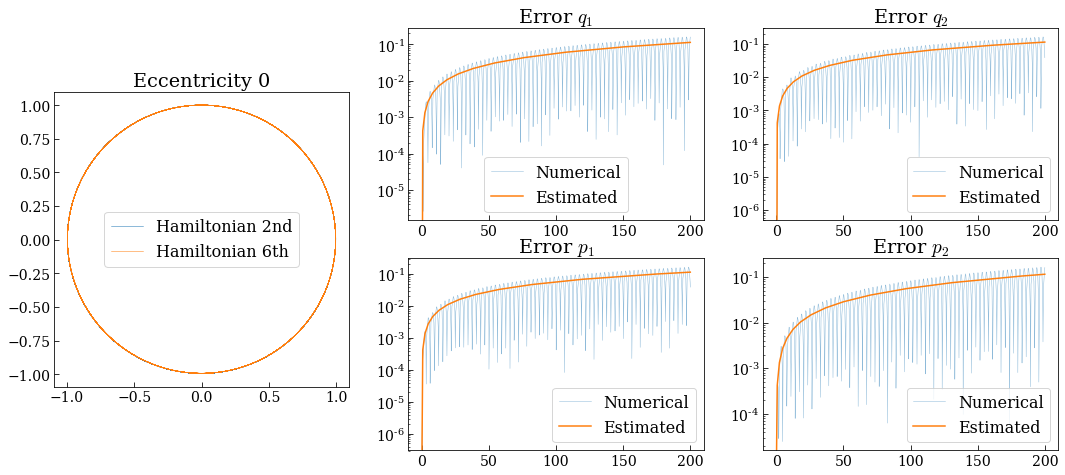

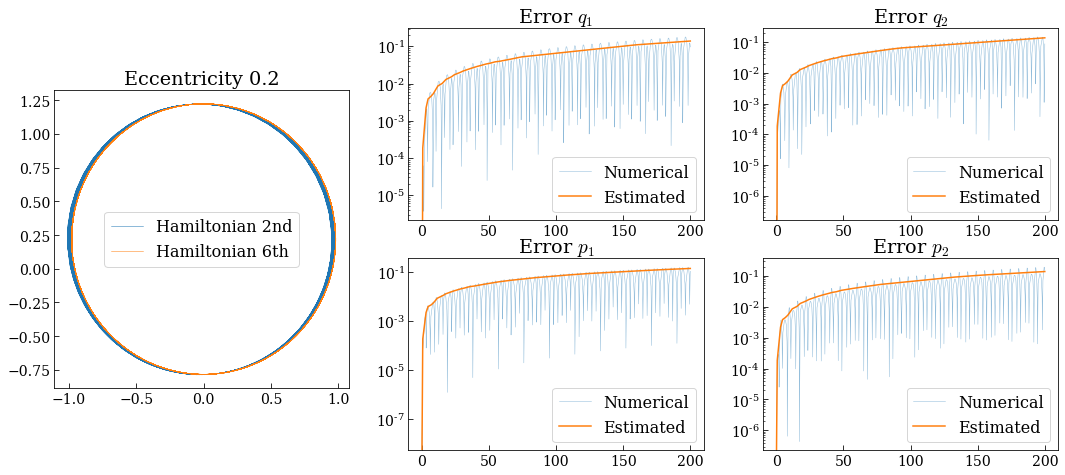

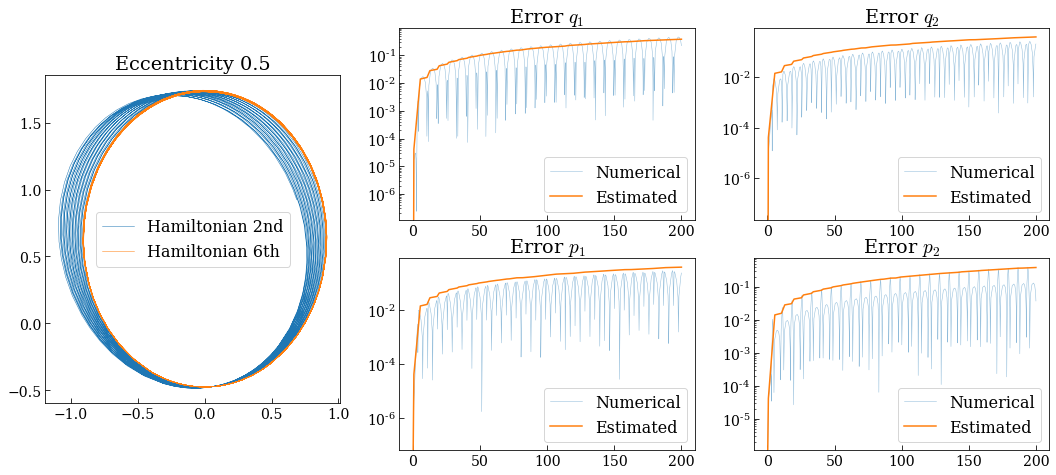

In [6]:
a=0.01
theta=2*np.pi
tpk = TimePerturbedKepler(a, theta, -1)
dt = 0.05
tf = 200
eccentricities = [0, 0.2, 0.5]
tspan = np.arange(0.0, tf, dt)

errq1 = lambda t,q1,q2,p1,p2,s: total_error_bound(t,q1,q2,p1,p2,s,dt,a,theta)
errq2 = lambda t,q1,q2,p1,p2,s: total_error_bound(t,q1,q2,p1,p2,s,dt,a,theta)
errp1 = lambda t,q1,q2,p1,p2,s: total_error_bound(t,q1,q2,p1,p2,s,dt,a,theta)
errp2 = lambda t,q1,q2,p1,p2,s: total_error_bound(t,q1,q2,p1,p2,s,dt,a,theta)

err = np.empty([len(tspan),4], dtype=np.float64)

for i,e in enumerate(eccentricities):
    
    p0, q0 = init_ecc(e)
    sol, sols, tspan = ic.integrate(ic.step, tpk, tspan, p0, q0, 0.0)
    solm, _solms, _ = ic.integrate(ic.step6, tpk, tspan, p0, q0, 0.0)
    err[:] = np.reshape(np.abs(sol-solm), (len(tspan),4), order="C")
    cumerr = np.array([n*dt**4 for n in range(len(tspan))])
    
    fig = plt.figure(figsize=(18,12))
    #plt.suptitle(f"$\\alpha = {a}$,$\\gamma = -1$, $e = {e}$, $\\tau = {dt}$",size=16)

    gs = matplotlib.gridspec.GridSpec(3, 3, figure=fig)
    ax = fig.add_subplot(gs[0:-1,0])
    ax.set_title(f"Eccentricity {e}")
    ax.set_aspect('equal', adjustable='box')
    ax.plot(sol[:,1,0],
             sol[:,1,1],
             linewidth=0.5, label="Hamiltonian 2nd")
    ax.plot(solm[:,1,0],
             solm[:,1,1],
             linewidth=0.5, label="Hamiltonian 6th")
    ax.legend()

    ax = fig.add_subplot(gs[0,1])
    ax.set_title("Error $q_1$")
    ax.plot(tspan, err[:,2], linewidth=0.5, alpha=0.5, label="Numerical")
    q1err = pad_and_cumsum([errq1(t,q1,q2,p1,p2,s) for t,q1,q2,p1,p2,s in zip(tspan,sol[:,1,0],sol[:,1,1],sol[:,0,0],sol[:,0,1],sols)])
    ax.plot(tspan, q1err,
         label="Estimated")
    # ax.fill_between(tspan, q1err-cumerr, q1err+cumerr, alpha=0.1, color="orange")
    ax.set_yscale('log')    
    ax.legend()

    ax = fig.add_subplot(gs[0,2])
    ax.set_title("Error $q_2$")
    ax.plot(tspan, err[:,3], linewidth=0.5, alpha=0.5, label="Numerical")
    q2err = pad_and_cumsum([errq2(t,q1,q2,p1,p2,s) for t,q1,q2,p1,p2,s in zip(tspan,sol[:,1,0],sol[:,1,1],sol[:,0,0],sol[:,0,1],sols)])
    ax.plot(tspan, q2err, label="Estimated")
    # ax.fill_between(tspan, q2err-cumerr, q2err+cumerr, alpha=0.1, color="orange")
    ax.set_yscale('log')
    ax.legend()

    ax = fig.add_subplot(gs[1,1])
    ax.set_title("Error $p_1$")
    ax.plot(tspan, err[:,0], linewidth=0.5, alpha=0.5, label="Numerical")
    p1err = pad_and_cumsum([errp1(t,q1,q2,p1,p2,s) for t,q1,q2,p1,p2,s in zip(tspan,sol[:,1,0],sol[:,1,1],sol[:,0,0],sol[:,0,1],sols)])
    ax.plot(tspan, p1err, label="Estimated")
    # ax.fill_between(tspan, p1err-cumerr, p1err+cumerr, alpha=0.1, color="orange")
    ax.set_yscale('log')
    ax.legend()

    ax = fig.add_subplot(gs[1,2])
    ax.set_title("Error $p_2$")
    ax.plot(tspan, err[:,1], linewidth=0.5, alpha=0.5, label="Numerical")
    p2err = pad_and_cumsum([errp2(t,q1,q2,p1,p2,s) for t,q1,q2,p1,p2,s in zip(tspan,sol[:,1,0],sol[:,1,1],sol[:,0,0],sol[:,0,1],sols)])
    ax.plot(tspan, p2err, label="Estimated")
    # ax.fill_between(tspan, p2err-cumerr, p2err+cumerr, alpha=0.1, color="orange")
    ax.set_yscale('log')
    ax.legend()

    plt.show()

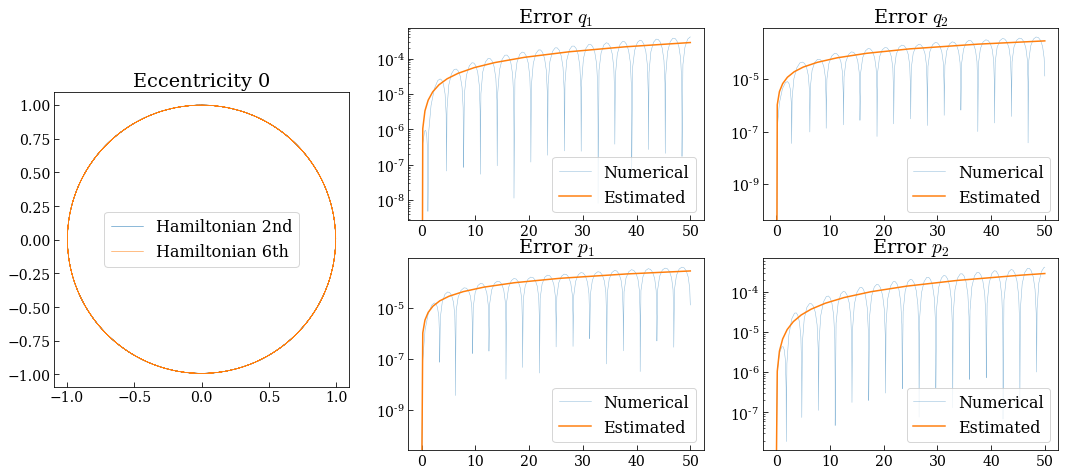

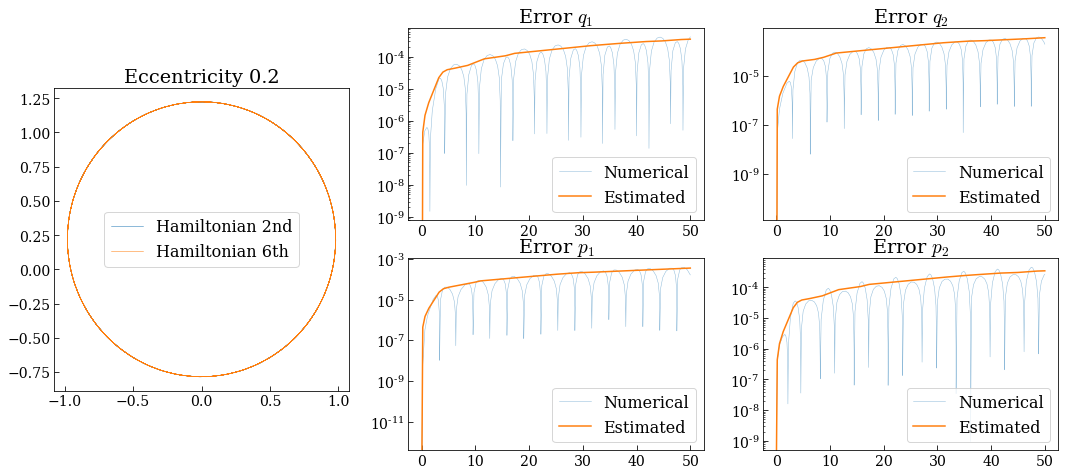

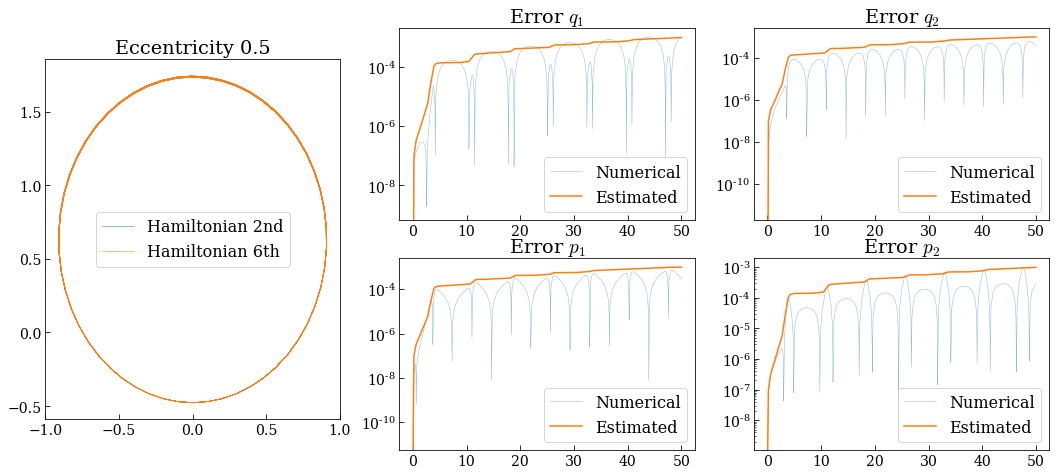

In [7]:
a=0.01
theta=2*np.pi
tpk = TimePerturbedKepler(a, theta, -1)
dt = 0.005
tf = 50
eccentricities = [0, 0.2, 0.5]
tspan = np.arange(0.0, tf, dt)

errq1 = lambda t,q1,q2,p1,p2,s: total_error_bound(t,q1,q2,p1,p2,s,dt,a,theta)
errq2 = lambda t,q1,q2,p1,p2,s: total_error_bound(t,q1,q2,p1,p2,s,dt,a,theta)
errp1 = lambda t,q1,q2,p1,p2,s: total_error_bound(t,q1,q2,p1,p2,s,dt,a,theta)
errp2 = lambda t,q1,q2,p1,p2,s: total_error_bound(t,q1,q2,p1,p2,s,dt,a,theta)

err = np.empty([len(tspan),4], dtype=np.float64)

for i,e in enumerate(eccentricities):
    
    p0, q0 = init_ecc(e)
    sol, sols, tspan = ic.integrate(ic.step, tpk, tspan, p0, q0, 0.0)
    solm, _solms, _ = ic.integrate(ic.step6, tpk, tspan, p0, q0, 0.0)
    err[:] = np.reshape(np.abs(sol-solm), (len(tspan),4), order="C")
    cumerr = np.array([n*dt**4 for n in range(len(tspan))])
    
    fig = plt.figure(figsize=(18,12))
    #plt.suptitle(f"$\\alpha = {a}$,$\\gamma = -1$, $e = {e}$, $\\tau = {dt}$",size=16)

    gs = matplotlib.gridspec.GridSpec(3, 3, figure=fig)
    ax = fig.add_subplot(gs[0:-1,0])
    ax.set_title(f"Eccentricity {e}")
    ax.set_aspect('equal', adjustable='box')
    ax.plot(sol[:,1,0],
             sol[:,1,1],
             linewidth=0.5, label="Hamiltonian 2nd")
    ax.plot(solm[:,1,0],
             solm[:,1,1],
             linewidth=0.5, label="Hamiltonian 6th")
    ax.legend()

    ax = fig.add_subplot(gs[0,1])
    ax.set_title("Error $q_1$")
    ax.plot(tspan, err[:,2], linewidth=0.5, alpha=0.5, label="Numerical")
    q1err = pad_and_cumsum([errq1(t,q1,q2,p1,p2,s) for t,q1,q2,p1,p2,s in zip(tspan,sol[:,1,0],sol[:,1,1],sol[:,0,0],sol[:,0,1],sols)])
    ax.plot(tspan, q1err,
         label="Estimated")
    # ax.fill_between(tspan, q1err-cumerr, q1err+cumerr, alpha=0.1, color="orange")
    ax.set_yscale('log')    
    ax.legend()

    ax = fig.add_subplot(gs[0,2])
    ax.set_title("Error $q_2$")
    ax.plot(tspan, err[:,3], linewidth=0.5, alpha=0.5, label="Numerical")
    q2err = pad_and_cumsum([errq2(t,q1,q2,p1,p2,s) for t,q1,q2,p1,p2,s in zip(tspan,sol[:,1,0],sol[:,1,1],sol[:,0,0],sol[:,0,1],sols)])
    ax.plot(tspan, q2err, label="Estimated")
    # ax.fill_between(tspan, q2err-cumerr, q2err+cumerr, alpha=0.1, color="orange")
    ax.set_yscale('log')
    ax.legend()

    ax = fig.add_subplot(gs[1,1])
    ax.set_title("Error $p_1$")
    ax.plot(tspan, err[:,0], linewidth=0.5, alpha=0.5, label="Numerical")
    p1err = pad_and_cumsum([errp1(t,q1,q2,p1,p2,s) for t,q1,q2,p1,p2,s in zip(tspan,sol[:,1,0],sol[:,1,1],sol[:,0,0],sol[:,0,1],sols)])
    ax.plot(tspan, p1err, label="Estimated")
    # ax.fill_between(tspan, p1err-cumerr, p1err+cumerr, alpha=0.1, color="orange")
    ax.set_yscale('log')
    ax.legend()

    ax = fig.add_subplot(gs[1,2])
    ax.set_title("Error $p_2$")
    ax.plot(tspan, err[:,1], linewidth=0.5, alpha=0.5, label="Numerical")
    p2err = pad_and_cumsum([errp2(t,q1,q2,p1,p2,s) for t,q1,q2,p1,p2,s in zip(tspan,sol[:,1,0],sol[:,1,1],sol[:,0,0],sol[:,0,1],sols)])
    ax.plot(tspan, p2err, label="Estimated")
    # ax.fill_between(tspan, p2err-cumerr, p2err+cumerr, alpha=0.1, color="orange")
    ax.set_yscale('log')
    ax.legend()

    plt.show()